In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityd,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [3]:
img1_dir = "../../Data/VFoldData/ROIData/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.overlay.nii.gz')))

num_classes = 2
num_slices = 48

num_workers_te = 0
batch_size_te = 1

output_dir = "."
model_filename_base = "BAMC_PTX_2DROI_3DUNet-4Class.best_model.vfold"

num_images = len(all_images)
print(num_images)
num_folds = 15

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

108
94 6 8
91 8 9
92 9 7
95 7 6
94 6 8
96 8 4
98 4 6
95 6 7
96 7 5
90 5 13
90 13 5
96 5 7
92 7 9
91 9 8
94 8 6


In [4]:
train_shape = itk.GetArrayFromImage(itk.imread(train_files[0][0]["image"])).shape
print(train_shape)

roi_size = list([train_shape[2],train_shape[1]])
roi_size = tuple(roi_size)

print(roi_size)

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        #Lambdad(
            #func=lambda x: np.where(x==2,1,0),
            #keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            center_slice=30,
            reduce_to_statistics=[True,False],
            keys=['image', 'label']),
        ScaleIntensityd(
            channel_wise=True,
            keys=["image"]),
        ToTensord(keys=["image", "label"]),
    ]
)

(61, 224, 128)
(128, 224)


In [5]:
test_ds = [Dataset(data=test_files[i], transform=test_transforms)
          for i in range(num_folds)]
test_loader = [DataLoader(test_ds[i], batch_size=batch_size_te, num_workers=num_workers_te)
              for i in range(num_folds)]

In [6]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:1")

In [10]:
def plot_vfold_training_curves(vfold_num, test_loader, min_size_comp, min_portion_comp, max_p0, min_p1, graph):
    if graph:
        print("   VFOLD =", vfold_num, "of", num_folds)
    
    correct = 0
    incorrect = 0
    
    slice_correct = 0
    slice_incorrect = 0
    
    false_negatives = 0
    slice_false_negatives = 0
    
    loss_file = os.path.join(output_dir, model_filename_base+"_loss_"+str(vfold_num)+".npy")
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
        
        metric_file = os.path.join(output_dir, model_filename_base+"_val_dice_"+str(vfold_num)+".npy")
        metric_values = np.load(metric_file)
    
        if graph:
            plt.figure("train", (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Epoch Average Loss")
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [2 * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.show()
    
    model_file = os.path.join(output_dir, model_filename_base+'_'+str(vfold_num)+'.pth')
    if os.path.exists(model_file):
        model = UNet(
            dimensions=2,
            in_channels=2,
            out_channels=num_classes,
            channels=(32, 64, 128, 32),
            strides=(1, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)    
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            fname = os.path.basename(test_files[vfold_num][i]["image"])
            prevfname = fname
            count1 = 0
            count = 0
            for b,test_data in enumerate(test_loader):
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, batch_size_te, model
                )
                for j in range(test_outputs.shape[0]):
                    prevfname = fname
                    fname = os.path.basename(test_files[vfold_num][i]["image"])
                    
                    if fname[:4]!=prevfname[:4]:
                        if graph:
                            print(prevfname[:4], "Counts per class = ", count1)
                        if count1 == count:
                            if graph:
                                print("  Winner = Sliding")
                            if prevfname[3] == 's':
                                correct += 1
                            else:
                                incorrect += 1
                                false_negatives += 1
                                print("FN Patient =", prevfname)
                        else:
                            if graph:
                                print("  Winner = Not Sliding")
                            if prevfname[3] == 'n':
                                correct += 1
                            else:
                                incorrect += 1
                                print("FP Patient =", prevfname)
                        if graph:
                            print()
                            print()
                        count1 = 0
                        count = 0
                    
                    itkP0 = itk.GetImageFromArray(test_outputs[j,0,:,:].cpu())
                    itkP1 = itk.GetImageFromArray(test_outputs[j,1,:,:].cpu())
                    imMathP0 = ttk.ImageMath.New(itkP0)
                    imMathP0.Blur(5)
                    itkP0 = imMathP0.GetOutput()
                    imMathP1 = ttk.ImageMath.New(itkP1)
                    imMathP1.Blur(5)
                    itkP1 = imMathP1.GetOutput()
                    arrc1 = np.zeros([itkP1.shape[0],itkP1.shape[1]])
                    for y in range(itkP1.shape[0]):
                        for x in range(itkP1.shape[1]):
                            if test_data["label"][j,0,y,x]>0:
                                if itkP1[y,x]>min_p1 and itkP0[y,x]<max_p0:
                                    arrc1[y,x] = 1
                    
                    max_size = np.count_nonzero(test_data["label"][j, 0, :, :].cpu()>0)
                    min_thresh = min(min_size_comp, max_size*min_portion_comp)
                    
                    itkc1 = itk.GetImageFromArray(arrc1.astype(np.float32))
                    imMathC1 = ttk.ImageMath.New(itkc1)
                    imMathC1.Erode(10,1,0)
                    imMathC1.Dilate(10,1,0)
                    itkc1 = imMathC1.GetOutputUChar()
                    connComp1 = ttk.SegmentConnectedComponents.New(itkc1)
                    connComp1.Update()
                    itkc1 = connComp1.GetOutput()
                    arrc1 = itk.GetArrayFromImage(itkc1)
                    slice_count1 = 0
                    for tc in range(1,arrc1.max()+1):
                        tf = np.count_nonzero(arrc1==tc)
                        if tf>slice_count1:
                            slice_count1 = tf
                    if slice_count1>min_thresh:
                        count1 += 1
                        if prevfname[3] == 's':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            slice_false_negatives += 1
                            print("   FN ROI =", fname)
                    else:
                        if prevfname[3] == 'n':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            print("   FP ROI =", fname)
                    count += 1
                    

                    if graph:
                        print(fname)

                        plt.figure("check", (18, 6))
                        plt.subplot(1, 3, 1)
                        plt.title(f"image {i}")
                        tmpV = test_data["image"][j, 1, :, :]
                        plt.imshow(tmpV, cmap="gray")
                        plt.subplot(1, 3, 2)
                        plt.title(f"label {i}")
                        tmpV = test_data["label"][j, 0, :, :]
                        tmpV[0,0]=1
                        tmpV[0,1]=2
                        tmpV[0,2]=3
                        plt.imshow(tmpV)
                        plt.subplot(1, 3, 3)
                        plt.title(f"output {i}")
                        arrc1[0,0]=1
                        arrc1[0,1]=2
                        arrc1[0,2]=3
                        plt.imshow(arrc1)
                        plt.show()

                        print("Number of sliding pixel =", slice_count1)
                        if slice_count1>min_thresh:
                            print("   Sliding")
                        else:
                            print("   NOT Sliding")
                        print()
                        print()

                        for c in range(num_classes):
                            arrimg = test_outputs.detach().cpu()[j,c,:,:]
                            itkimg = itk.GetImageFromArray(arrimg)
                            filename = "prob_f"+str(b)+"_i"+str(j)+"_c"+str(c)+".mha"
                            itk.imwrite(itkimg, filename)
                    
                    i += 1
                    
            if graph:
                print(prevfname[:4], "Counts per class = ", count1)
            if count1 == count:
                if graph:
                    print("  Winner = Sliding")
                if prevfname[3] == 's':
                    correct += 1
                else:
                    incorrect += 1
                    false_negatives += 1
                    print("FN Patient =", fname)
            else:
                if graph:
                    print("  Winner = Not Sliding")
                if prevfname[3] == 'n':
                    correct += 1
                else:
                    incorrect += 1
                    print("FP Patient =", fname)
            if graph:
                print()
                print()
                
    return correct, incorrect, false_negatives, slice_correct, slice_incorrect, slice_false_negatives

In [11]:
min_size = 1000
min_portion = 0.25
gap_start = 999
#gaps = [num/1000 for num in range(gap_start, 500, -50)]
gaps = [0.6]
print(gaps)

[0.6]


min_p1 = 0.6  max_p0 = 0.4  min_size = 1500  min_portion = 0.2
   VFOLD = 0 of 15


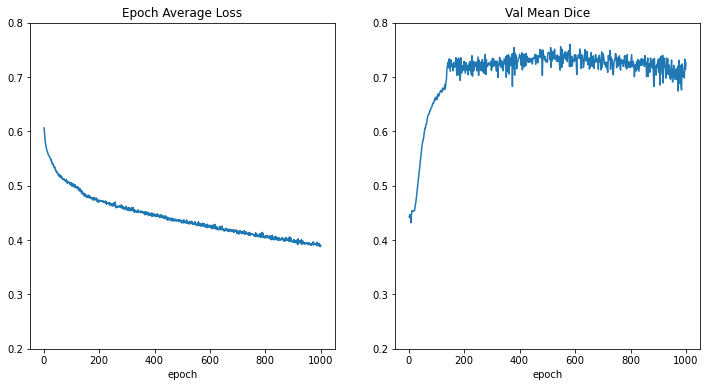

236s_iimage_1139765223418_CLEAN_ClassS_166-294.roi.nii.gz


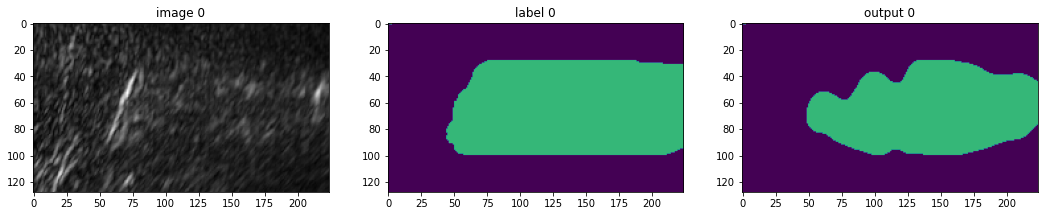

Number of sliding pixel = 9469
   Sliding


236s_iimage_1139765223418_CLEAN_ClassS_66-194.roi.nii.gz


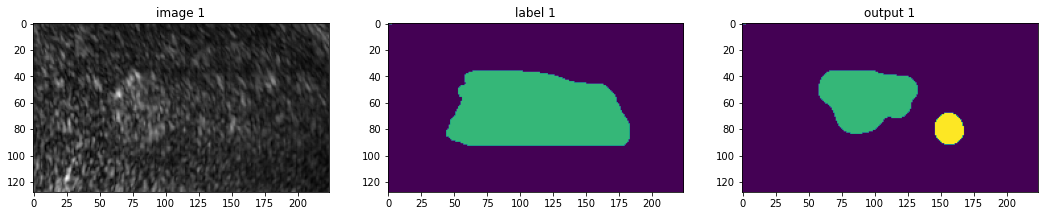

Number of sliding pixel = 2642
   Sliding


236s_iimage_1327616672148_clean_ClassS_158-286.roi.nii.gz


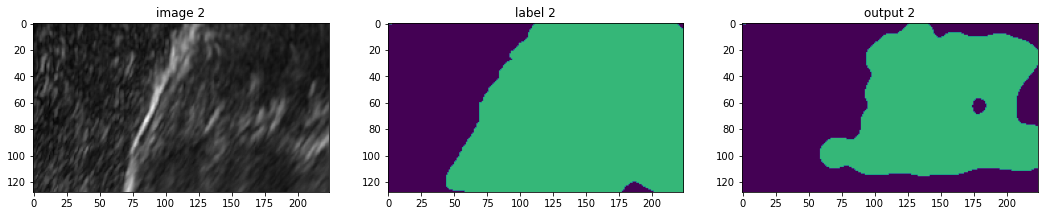

Number of sliding pixel = 13759
   Sliding


236s Counts per class =  3
  Winner = Sliding


237s_iimage_24164968068436_CLEAN_ClassS_172-300.roi.nii.gz


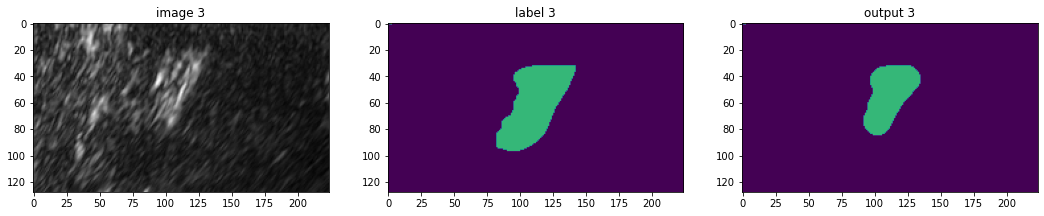

Number of sliding pixel = 1441
   Sliding


237s_iimage_24164968068436_CLEAN_ClassS_38-166.roi.nii.gz


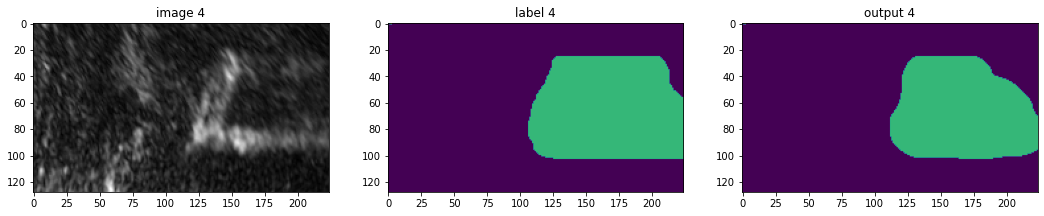

Number of sliding pixel = 7187
   Sliding


237s Counts per class =  2
  Winner = Sliding


247ns_image_2734882394424_CLEAN_ClassN_83-211.roi.nii.gz


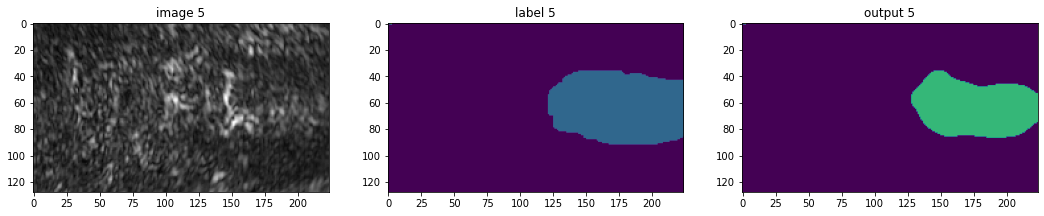

Number of sliding pixel = 3620
   Sliding


247ns_image_2743083265515_CLEAN_ClassN_126-254.roi.nii.gz


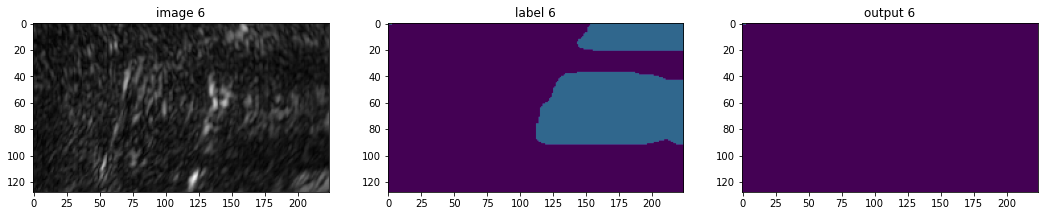

Number of sliding pixel = 0
   NOT Sliding


   FN ROI = 247ns_image_2743083265515_CLEAN_ClassN_60-188.roi.nii.gz
247ns_image_2743083265515_CLEAN_ClassN_60-188.roi.nii.gz


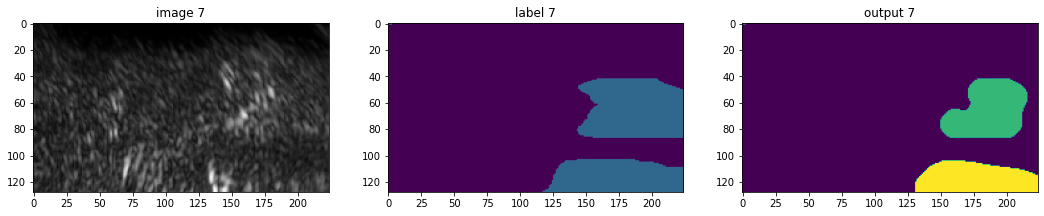

Number of sliding pixel = 2215
   Sliding


247n Counts per class =  2
  Winner = Not Sliding


   VFOLD = 1 of 15


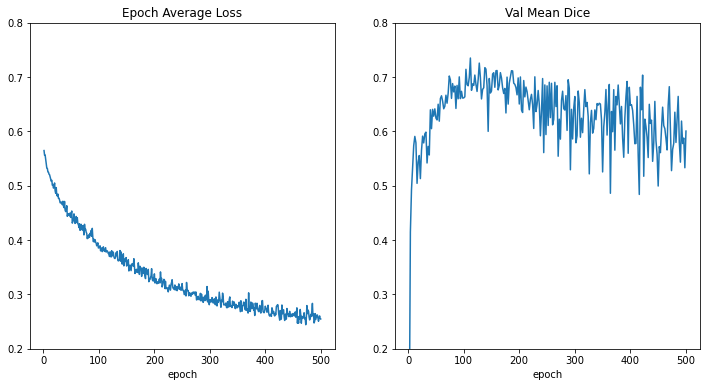

004s_iimage_73815992352100_clean_ClassS_179-307.roi.nii.gz


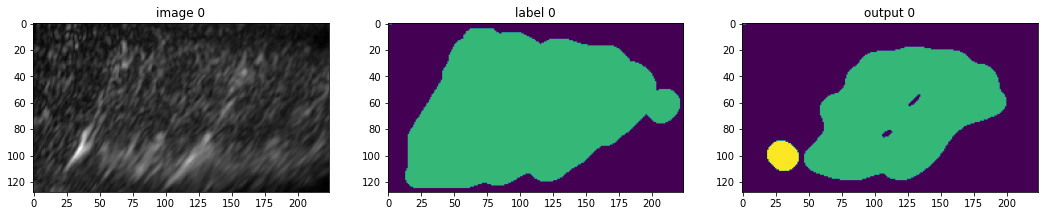

Number of sliding pixel = 10417
   Sliding


004s_iimage_73815992352100_clean_ClassS_70-198.roi.nii.gz


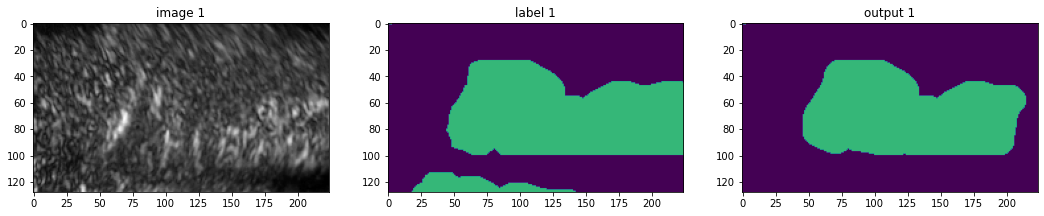

Number of sliding pixel = 9285
   Sliding


   FP ROI = 004s_iimage_74132233134844_clean_ClassS_192-320.roi.nii.gz
004s_iimage_74132233134844_clean_ClassS_192-320.roi.nii.gz


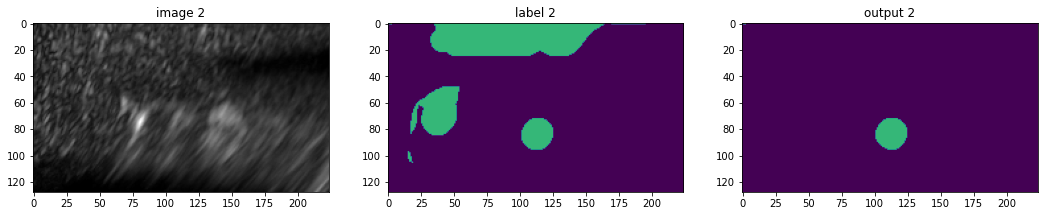

Number of sliding pixel = 457
   NOT Sliding


004s_iimage_74132233134844_clean_ClassS_86-214.roi.nii.gz


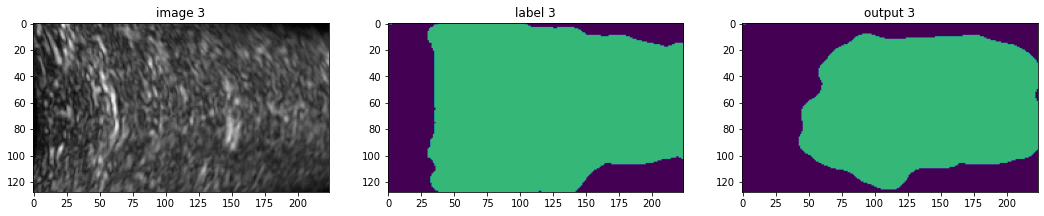

Number of sliding pixel = 16721
   Sliding


004s Counts per class =  3
  Winner = Not Sliding
FP Patient = 004s_iimage_74132233134844_clean_ClassS_86-214.roi.nii.gz


   FP ROI = 025ns_Image_262499828648_clean_ClassN_125-253.roi.nii.gz
025ns_Image_262499828648_clean_ClassN_125-253.roi.nii.gz


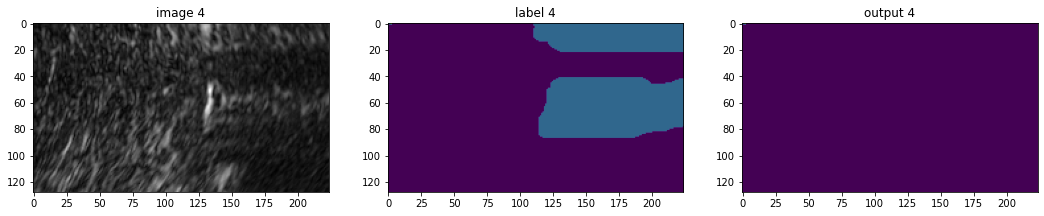

Number of sliding pixel = 0
   NOT Sliding


025ns_Image_262499828648_clean_ClassN_57-185.roi.nii.gz


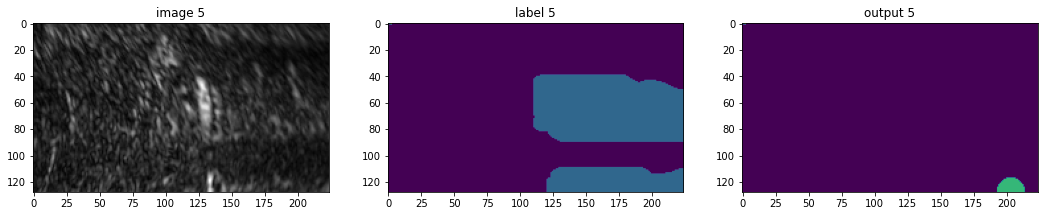

Number of sliding pixel = 185
   NOT Sliding


   FN ROI = 025ns_image_267456908021_clean_ClassN_0-128.roi.nii.gz
025ns_image_267456908021_clean_ClassN_0-128.roi.nii.gz


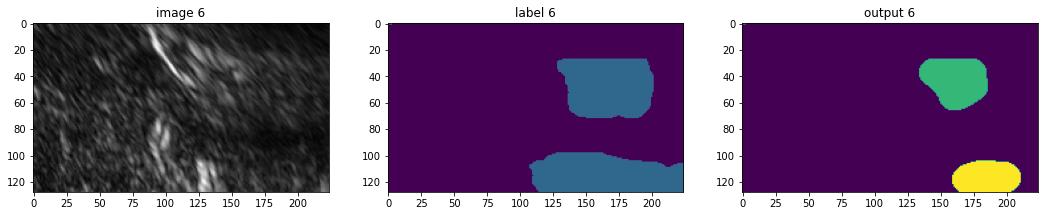

Number of sliding pixel = 1564
   Sliding


   FN ROI = 025ns_image_267456908021_clean_ClassN_131-259.roi.nii.gz
025ns_image_267456908021_clean_ClassN_131-259.roi.nii.gz


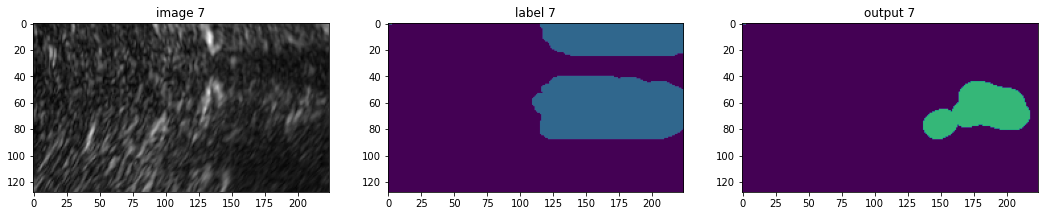

Number of sliding pixel = 2141
   Sliding


   FN ROI = 025ns_image_267456908021_clean_ClassN_63-191.roi.nii.gz
025ns_image_267456908021_clean_ClassN_63-191.roi.nii.gz


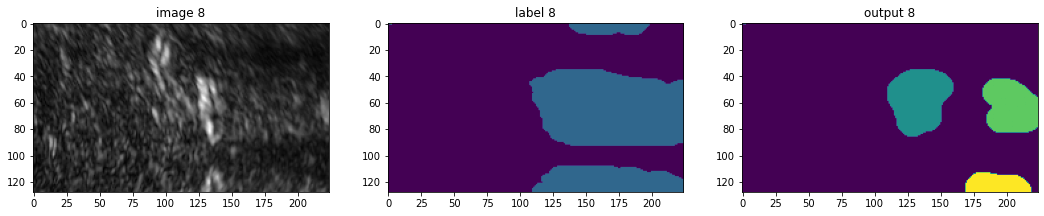

Number of sliding pixel = 1882
   Sliding


025n Counts per class =  3
  Winner = Not Sliding


   Patients: Correct = 4 Incorrect = 1 Not Sliding as Sliding = 0
     Slices: Correct = 11 Incorrect =  6 Not Sliding as Sliding = 4


In [14]:
for min_portion in [0.2]:
    for min_size in [1500]:
        for gap in gaps:
            min_p1 = gap
            max_p0 = (1.0-gap)
            print("min_p1 =", min_p1, " max_p0 =", max_p0, " min_size =", min_size, " min_portion =", min_portion)
            correct = 0
            incorrect = 0
            false_negatives = 0
            slice_correct = 0
            slice_incorrect = 0
            slice_false_negatives = 0
            for i in range(2): #num_folds
                (fcorrect, fincorrect, ffalse_negatives, fslice_correct, fslice_incorrect, fslice_false_negatives) = plot_vfold_training_curves(i, test_loader[i],
                    min_size, min_portion, max_p0, min_p1, True)
                correct += fcorrect
                incorrect += fincorrect
                false_negatives += ffalse_negatives
                slice_correct += fslice_correct
                slice_incorrect += fslice_incorrect
                slice_false_negatives += fslice_false_negatives
            print("   Patients: Correct =", correct, "Incorrect =", incorrect, "Not Sliding as Sliding =", false_negatives)
            print("     Slices: Correct =", slice_correct, "Incorrect = ", slice_incorrect, "Not Sliding as Sliding =", slice_false_negatives)